In [ ]:
! /opt/bin/nvidia-smi

Sat May  8 23:45:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip -q install gputil
!pip -q install psutil
!pip -q install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 118.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
# install nlp
!pip install -qq nlp==0.2.0

# Make sure that we have a recent version of pyarrow in the session before we continue - otherwise reboot Colab to activate it
import pyarrow
# if int(pyarrow.__version__.split('.')[1]) < 16:
#     import os
#     os.kill(os.getpid(), 9)

!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-wx6qssp7
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-wx6qssp7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2213074 sha256=b5d5dbeae47983356a7e25fdf2d3ff62c68c77a3c4e6970dca052cd4cabc6b84
  Stored in directory: /tmp/pip-ephem-wheel-cache-hza3bd7i/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers


In [ ]:
# imports
from transformers import (
    ReformerForMaskedLM,
    ReformerTokenizer,
    ReformerConfig,
    Trainer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    TrainerCallback,
)
import nlp
import torch
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt

In [ ]:
# load the dataset
dataset = nlp.load_dataset("crime_and_punish", split="train")
# get a pretrained tokenizer
tokenizer = ReformerTokenizer.from_pretrained("google/reformer-crime-and-punishment")
tokenizer.add_special_tokens({"mask_token": '[MASK]'})
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

sequence_length = 2 ** 12  # 16384

# define our map function to reduce the dataset to one sample
def flatten_and_tokenize(batch):
  all_input_text = ["".join(batch["line"])]
  print(sequence_length)
  input_ids_dict = tokenizer(all_input_text, pad_to_max_length=True, max_length=sequence_length, truncation=True)

  # duplicate data 8 times to have have 8 examples in dataset
  for key in input_ids_dict.keys():
    input_ids_dict[key] = [4 * [x] for x in input_ids_dict[key]][0]

  return input_ids_dict

# reduce the dataset and set batch_size to all inputs
dataset = dataset.map(
  flatten_and_tokenize, batched=True, batch_size=-1, remove_columns=["line"]
)

# prepare dataset to be in torch format
dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
print(dataset['input_ids'].shape)
print(dataset['attention_mask'].shape)

4096
4096
torch.Size([4, 4096])
torch.Size([4, 4096])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
class MLMReformerDataset(Dataset):

  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, i):
    return self.dataset['input_ids'][i]

mlm_dataset = MLMReformerDataset(dataset)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

Next, we will define our reformer model by defining the `ReformerConfig`. 
For the sake of this notebook, the `google/reformer-enwik8` config is taken whereas the vocabulary size is adapted to be used with our tokenizer.

In [ ]:
separate_q_k_config = {
  "attention_head_size": 128,
  "attn_layers": [
    "local",
    "local",
    "local",
    "local",
    "local",
    "local",
    "local",
    "local",
    "local",
    "local",
    "local",
    "local",
  ],
  "axial_norm_std": 1.0,
  "axial_pos_embds": False,
  "chunk_size_feed_forward": 0,
  "chunk_size_lm_head": 0,
  "eos_token_id": 2,
  "feed_forward_size": 4096,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "is_decoder": False,
  "layer_norm_eps": 1e-12,
  "local_attention_probs_dropout_prob": 0.2,
  "local_attn_chunk_length": 4096,
  "local_num_chunks_after": 0,
  "local_num_chunks_before": 0,
  "lsh_attention_probs_dropout_prob": 0.1,
  "lsh_attn_chunk_length": 4096,
  "lsh_num_chunks_after": 0,
  "lsh_num_chunks_before": 0,
  "max_position_embeddings": 4096,
  "model_type": "reformer",
  "num_attention_heads": 8,
  "num_buckets": 512,
  "num_hashes": 1,
  "pad_token_id": 0,
  "vocab_size": 322  # +1 for [MASK] token
}

separate_q_k_config = ReformerConfig(**separate_q_k_config)
separate_q_k_model = ReformerForMaskedLM(separate_q_k_config)
separate_q_k_model = separate_q_k_model.train()
# define the training args
separate_q_k_training_args = {
    "num_train_epochs": 500,
    "logging_steps": 4,
    "warmup_steps": 0,
    # "weight_decay": 0.001,
    "per_device_train_batch_size": 1,
    "per_device_train_batch_size": 1,
    "logging_dir": "./logs",
    "output_dir": "./"
}

separate_q_k_training_args = TrainingArguments(**separate_q_k_training_args)
# create the trainer
separate_q_k_trainer = Trainer(
    model=separate_q_k_model,
    args=separate_q_k_training_args,
    data_collator=data_collator,
    train_dataset=mlm_dataset,
)
 
separate_steps = []
separate_loss = []
class SeparateLossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        separate_steps.append(log['step'])
        separate_loss.append(log['loss'])
      print(separate_steps, separate_loss)

separate_q_k_trainer.add_callback(SeparateLossCallback())
# train
separate_q_k_trainer.train()

Step,Training Loss
4,6.000200
8,5.574100
12,5.397600
16,5.350000
20,5.348400
24,5.292500
28,5.277900
32,5.325200
36,5.240300
40,5.231500


[4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 820, 

TrainOutput(global_step=2000, training_loss=0.5894317746041342, metrics={'train_runtime': 3771.4728, 'train_samples_per_second': 0.53, 'total_flos': 0, 'epoch': 500.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 625423872, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -584028160, 'train_mem_gpu_alloc_delta': 1876300800, 'train_mem_cpu_peaked_delta': 584495104, 'train_mem_gpu_peaked_delta': 4190438912})

In [ ]:
torch.cuda.empty_cache()

In [ ]:
shared_q_k_config = {
  "attention_head_size": 128,
  "attn_layers": [
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
  ],
  "axial_norm_std": 1.0,
  "axial_pos_embds": False,
  "chunk_size_feed_forward": 0,
  "chunk_size_lm_head": 0,
  "eos_token_id": 2,
  "feed_forward_size": 4096,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "is_decoder": False,
  "layer_norm_eps": 1e-12,
  "local_attention_probs_dropout_prob": 0.2,
  "local_attn_chunk_length": 4096,
  "local_num_chunks_after": 0,
  "local_num_chunks_before": 0,
  "lsh_attention_probs_dropout_prob": 0.1,
  "lsh_attn_chunk_length": 4096,
  "lsh_num_chunks_after": 0,
  "lsh_num_chunks_before": 0,
  "max_position_embeddings": 4096,
  "model_type": "reformer",
  "num_attention_heads": 8,
  "num_buckets": 512,
  "num_hashes": 1,
  "pad_token_id": 0,
  "vocab_size": 322  # +1 for [MASK] token
}

shared_q_k_config = ReformerConfig(**shared_q_k_config)
shared_q_k_model = ReformerForMaskedLM(shared_q_k_config)
shared_q_k_model = shared_q_k_model.train()
# define the training args
shared_q_k_training_args = {
    "num_train_epochs": 500,
    "logging_steps": 4,
    "warmup_steps": 0,
    # "weight_decay": 0.001,
    "per_device_train_batch_size": 1,
    "per_device_train_batch_size": 1,
    "logging_dir": "./logs",
    "output_dir": "./"
}

shared_q_k_training_args = TrainingArguments(**shared_q_k_training_args)
# create the trainer
shared_q_k_trainer = Trainer(
    model=shared_q_k_model,
    args=shared_q_k_training_args,
    data_collator=data_collator,
    train_dataset=mlm_dataset,
)
 
shared_steps = []
shared_loss = []
class SharedLossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        shared_steps.append(log['step'])
        shared_loss.append(log['loss'])
      print(shared_steps, shared_loss)

shared_q_k_trainer.add_callback(SharedLossCallback())
# train
shared_q_k_trainer.train()

Step,Training Loss
4,5.992500
8,5.502700
12,5.378300
16,5.312200
20,5.321000
24,5.253500
28,5.276300
32,5.316600
36,5.283500
40,5.275700


[4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 820, 

TrainOutput(global_step=2000, training_loss=0.7596611221060157, metrics={'train_runtime': 4095.1724, 'train_samples_per_second': 0.488, 'total_flos': 0, 'epoch': 500.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 575104512, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -534102016, 'train_mem_gpu_alloc_delta': 1725305856, 'train_mem_cpu_peaked_delta': 534274048, 'train_mem_gpu_peaked_delta': 4341564928})

In [ ]:
shared_q_k_4_config = {
  "attention_head_size": 128,
  "attn_layers": [
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
  ],
  "axial_norm_std": 1.0,
  "axial_pos_embds": False,
  "chunk_size_feed_forward": 0,
  "chunk_size_lm_head": 0,
  "eos_token_id": 2,
  "feed_forward_size": 4096,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "is_decoder": False,
  "layer_norm_eps": 1e-12,
  "local_attention_probs_dropout_prob": 0.2,
  "local_attn_chunk_length": 4096,
  "local_num_chunks_after": 0,
  "local_num_chunks_before": 0,
  "lsh_attention_probs_dropout_prob": 0.1,
  "lsh_attn_chunk_length": 4096,
  "lsh_num_chunks_after": 0,
  "lsh_num_chunks_before": 0,
  "max_position_embeddings": 4096,
  "model_type": "reformer",
  "num_attention_heads": 8,
  "num_buckets": 512,
  "num_hashes": 4,
  "pad_token_id": 0,
  "vocab_size": 322  # +1 for [MASK] token
}

shared_q_k_4_config = ReformerConfig(**shared_q_k_4_config)
shared_q_k_4_model = ReformerForMaskedLM(shared_q_k_4_config)
shared_q_k_4_model = shared_q_k_4_model.train()
# define the training args
shared_q_k_4_training_args = {
    "num_train_epochs": 200,
    "logging_steps": 4,
    "warmup_steps": 0,
    # "weight_decay": 0.001,
    "per_device_train_batch_size": 1,
    "per_device_train_batch_size": 1,
    "logging_dir": "./logs",
    "output_dir": "./"
}

shared_q_k_4_training_args = TrainingArguments(**shared_q_k_4_training_args)
# create the trainer
shared_q_k_4_trainer = Trainer(
    model=shared_q_k_4_model,
    args=shared_q_k_4_training_args,
    data_collator=data_collator,
    train_dataset=mlm_dataset,
)
 
shared_q_k_4_steps = []
shared_q_k_4_loss = []
class SharedLossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        shared_q_k_4_steps.append(log['step'])
        shared_q_k_4_loss.append(log['loss'])
      print(shared_steps, shared_loss)

shared_q_k_4_trainer.add_callback(SharedLossCallback())
# train
shared_q_k_4_trainer.train()

In [ ]:
shared_q_k_8_config = {
  "attention_head_size": 128,
  "attn_layers": [
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
    "lsh",
  ],
  "axial_norm_std": 1.0,
  "axial_pos_embds": False,
  "chunk_size_feed_forward": 0,
  "chunk_size_lm_head": 0,
  "eos_token_id": 2,
  "feed_forward_size": 4096,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "is_decoder": False,
  "layer_norm_eps": 1e-12,
  "local_attention_probs_dropout_prob": 0.2,
  "local_attn_chunk_length": 4096,
  "local_num_chunks_after": 0,
  "local_num_chunks_before": 0,
  "lsh_attention_probs_dropout_prob": 0.1,
  "lsh_attn_chunk_length": 4096,
  "lsh_num_chunks_after": 0,
  "lsh_num_chunks_before": 0,
  "max_position_embeddings": 4096,
  "model_type": "reformer",
  "num_attention_heads": 8,
  "num_buckets": 512,
  "num_hashes": 4,
  "pad_token_id": 0,
  "vocab_size": 322  # +1 for [MASK] token
}

shared_q_k_8_config = ReformerConfig(**shared_q_k_8_config)
shared_q_k_8_model = ReformerForMaskedLM(shared_q_k_8_config)
shared_q_k_8_model = shared_q_k_8_model.train()
# define the training args
shared_q_k_8_training_args = {
    "num_train_epochs": 200,
    "logging_steps": 4,
    "warmup_steps": 0,
    # "weight_decay": 0.001,
    "per_device_train_batch_size": 1,
    "per_device_train_batch_size": 1,
    "logging_dir": "./logs",
    "output_dir": "./"
}

shared_q_k_8_training_args = TrainingArguments(**shared_q_k_8_training_args)
# create the trainer
shared_q_k_8_trainer = Trainer(
    model=shared_q_k_8_model,
    args=shared_q_k_8_training_args,
    data_collator=data_collator,
    train_dataset=mlm_dataset,
)
 
shared_q_k_8_steps = []
shared_q_k_8_loss = []
class SharedLossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        shared_q_k_8_steps.append(log['step'])
        shared_q_k_8_loss.append(log['loss'])
      print(shared_steps, shared_loss)

shared_q_k_8_trainer.add_callback(SharedLossCallback())
# train
shared_q_k_8_trainer.train()

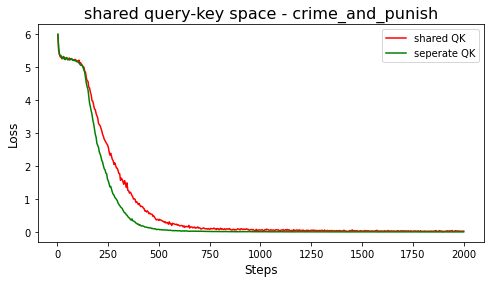

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(shared_steps, shared_loss, c="r", label="shared QK")
ax.plot(separate_steps, separate_loss, c="g", label="seperate QK")
ax.legend()
ax.set_xlabel("Steps", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("shared query-key space - crime_and_punish", fontsize=16)
plt.show()